In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import rgb2hex
import torch

In [24]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)
df

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,1.871008e-01,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,2.454175e-01,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,1.766153e-01,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,2.383027e-01,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,2.081967e-01,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.152128,30.721298,45.274497,0.791801,41.934347,0.000380,-2.000169,1.097528,62.147780,38.653720,23.989078,-8.116730e-60,71
1330812,-2.258684,30.721306,45.239017,0.778900,41.868923,0.002985,-2.000499,1.097569,62.142646,38.656328,23.970700,-5.815891e-60,71
1330813,-2.130312,30.721312,45.211576,0.804914,41.804819,0.002301,-1.999268,1.098765,62.138387,38.650923,23.977234,-4.167268e-60,71
1330814,-2.268498,30.721316,45.193508,0.763091,41.762220,0.005662,-2.000999,1.095696,62.133422,38.655686,24.001421,-2.985978e-60,71


In [25]:
#Sorting the value of the measurement sessions

#The 'mergesort' algorithm is a stable sort, meaning that it maintains the
#relative order of rows with equal 'profile_id' values. However, this code
#creates a new DataFrame sorted_df with the sorted data.
print(df.head(10))
df.sort_values(by='profile_id', kind='mergesort', inplace=True)
unique_values = df['profile_id'].unique()
print(unique_values)

        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   
5 -0.538973  18.901548       19.077108  0.009147     18.290628     0.009636   
6 -0.653148  18.941711       19.074583  0.238890     18.292524     0.001337   
7 -0.758392  18.960861       19.082499  0.395099     18.294041     0.001422   
8 -0.727128  18.973545       19.085533  0.546623     18.291964     0.000577   
9 -0.874307  18.987812       19.076025  0.578944     18.287233    -0.001248   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19

In [26]:
# Remove the specified columns
df.drop(['stator_tooth', 'coolant', 'stator_winding', 'torque'], axis=1, inplace=True)

In [27]:
# Let's rename the stator_yoke variable to stator_temp
df.rename(columns={'stator_yoke': 'stator_temp'}, inplace=True)

# Check the first few rows to confirm the columns are removed
print(df.head())

            u_q       u_d  motor_speed       i_d       i_q         pm  \
90975  4.921712  0.051183    99.964539 -0.000385  0.000221  23.153740   
90976  4.948537  0.074807   100.017822 -0.002003  0.000886  23.153469   
90977  4.941477  0.063648    99.999977  0.000156 -0.000046  23.147993   
90978  4.921178  0.076738    99.980309  0.001466 -0.001133  23.135658   
90979  4.924347  0.084553   100.023392  0.000682  0.003452  23.137959   

       stator_temp    ambient  profile_id  
90975    18.395088  19.995035           2  
90976    18.376493  19.954098           2  
90977    18.371748  19.924765           2  
90978    18.375002  19.903748           2  
90979    18.378679  19.888687           2  


In [28]:
#function to trim sessions to an appropriate size
def preprocess(df, sessions_id, seq_len, target="pm"):
    sessions = []
    for id in sessions_id:
        s = df[df["profile_id"] == id]

        #because the sequences based on the profile_id are not all the same lenghts, it takes the longest number of 
        #timestamps that is divisible for the seq_len that will be passed to our model

        #for each sequences we will lost a little bit of the dataset ( no more than the sequence_length = 100)
        r = len(s) % seq_len
        l = len(s) - r
        
        session = s.iloc[:l]
        
        y = session[target]
        X = session.drop([target, "profile_id"], axis=1)
        
        X = torch.from_numpy(X.values).float() 
        y = torch.from_numpy(y.values).float()

        sessions.append((X, y))
        
    return sessions

***Class Definition***

class NET(nn.Module): This line defines a new class NET that inherits from PyTorch's nn.Module. In PyTorch, nn.Module is the base class for all neural network modules, and your NET class is a custom module.

***Constructor (__init__ method)***

def __init__(self, in_size, h_size, n_layers, out_size): This is the constructor of the NET class. It is called when you create an instance of NET. The constructor takes four parameters:

features_size: The size of the input features.

hydden_size: The size of the hidden layers.

n_layers: The number of layers in the LSTM.

out_size: The size of the output.

Inside the constructor, you define the layers of the neural network:

self.lstm: An LSTM layer. 

nn.LSTM(features_size, hydden_size, n_layers, batch_first=True, bidirectional=True) creates a bidirectional LSTM. 

batch_first=True indicates that the input tensors will have a batch size as the first dimension. bidirectional=True means that the LSTM will process the data in both forward and backward directions, which can capture patterns from both ends of the sequence.

self.fc: A fully connected (linear) layer. 

nn.Linear(h_size * 2, out_size) creates a linear layer that maps from the hidden state space to the output space. The factor of 2 is used because the LSTM is bidirectional, so the hidden state's size is doubled.

***Forward Pass (forward method)***

def forward(self, x): This method defines the forward pass of the network. It takes an input tensor x and defines how it passes through the network.

h0 and c0: Initial states for the LSTM. These are tensors of zeros with appropriate shapes [num_layers*num_directions, batch_size, hidden_size]. For a bidirectional LSTM, num_directions is 2.

out, _ = self.lstm(x, (h0, c0)): This line passes the input x and the initial hidden states through the LSTM. The LSTM outputs the output tensor out and the new hidden states (which are not used further in this model).

out = self.fc(out): The output of the LSTM is then passed through the fully connected layer.

In [29]:
import torch.nn as nn

#Bidirectional LSTM class
class NET(nn.Module):
    def __init__(self, features_size, hydden_size, n_layers, out_size):
        super(NET, self).__init__()
        self.hydden_size = hydden_size
        self.n_layers = n_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(features_size, hydden_size, n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hydden_size * 2, out_size)
             
    def forward(self, x):
        #init. states 
        h0 = torch.zeros(self.n_layers * 2, x.size(0), self.hydden_size)
        c0 = torch.zeros(self.n_layers * 2, x.size(0), self.hydden_size)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out)
        return out 

In [30]:
def find_dominant_profile_ids(df):
    # Calculate the frequency of each profile_id
    profile_counts = df['profile_id'].value_counts()

    # Calculate the cumulative percentage of each profile_id
    cumulative_percentage = profile_counts.cumsum() / profile_counts.sum() * 100

    # Find the profile_ids that together make up at least 80% of the dataset
    dominant_profile_ids = cumulative_percentage[cumulative_percentage <= 80].index.tolist()

    return dominant_profile_ids


training_ids = find_dominant_profile_ids(df)

print(training_ids)


[20, 6, 65, 18, 66, 13, 27, 4, 58, 56, 53, 79, 44, 70, 62, 30, 80, 74, 68, 36, 76, 48, 12, 29, 32, 16, 9, 2, 3, 8, 14, 15, 81, 21, 45, 42, 73, 41, 63, 26, 17, 31, 69]


In [31]:
#defining the sequence length and the sessions ids which are used for training
seq_len = 100

In [33]:
#creating the training_set

training_set = preprocess(df, training_ids, seq_len)
print(training_set)

#create an lstm instance
model_LSTM = NET(7, 20, 2, 1)
print(model_LSTM)

#define optimizer and loss function
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=0.001)
criterion = nn.MSELoss()

[(tensor([[-7.4454e-01,  8.8918e-01, -2.2187e-03,  ...,  1.0787e+00,
          1.8587e+01,  2.1449e+01],
        [-6.9469e-01,  5.8200e-01, -3.3035e-03,  ...,  1.0821e+00,
          1.8588e+01,  2.1379e+01],
        [-8.5487e-01,  6.3217e-01, -1.8062e-03,  ...,  1.0841e+00,
          1.8595e+01,  2.1377e+01],
        ...,
        [ 5.1924e+01, -1.2069e+02,  3.3000e+03,  ...,  1.0903e+02,
          4.5986e+01,  2.6383e+01],
        [ 5.1937e+01, -1.2067e+02,  3.3000e+03,  ...,  1.0901e+02,
          4.5986e+01,  2.6383e+01],
        [ 5.1850e+01, -1.2064e+02,  3.3000e+03,  ...,  1.0901e+02,
          4.5986e+01,  2.6384e+01]]), tensor([23.5498, 23.5633, 23.5585,  ..., 80.7286, 80.7187, 80.7158])), (tensor([[ 1.9500e+00, -1.2030e+00,  4.0930e-02,  ...,  6.2350e+01,
          1.8211e+01,  2.3193e+01],
        [ 2.0501e+00, -1.3041e+00,  3.0431e-02,  ...,  6.4744e+01,
          1.8225e+01,  2.3216e+01],
        [ 2.1196e+00, -1.3733e+00,  2.5718e-02,  ...,  6.6459e+01,
          1.8220e+01

**Train First LSTM model**

Epoch [1/30], Loss: 4426.4990
Epoch [2/30], Loss: 3988.3049
Epoch [3/30], Loss: 3642.0518
Epoch [4/30], Loss: 3378.7375
Epoch [5/30], Loss: 3155.6816
Epoch [6/30], Loss: 2959.3877
Epoch [7/30], Loss: 2780.4104
Epoch [8/30], Loss: 2615.0579
Epoch [9/30], Loss: 2460.4089
Epoch [10/30], Loss: 2316.9102
Epoch [11/30], Loss: 2182.7339
Epoch [12/30], Loss: 2057.0173
Epoch [13/30], Loss: 1939.1241
Epoch [14/30], Loss: 1828.3734
Epoch [15/30], Loss: 1724.5192
Epoch [16/30], Loss: 1627.0853
Epoch [17/30], Loss: 1535.6847
Epoch [18/30], Loss: 1449.9752
Epoch [19/30], Loss: 1369.6624
Epoch [20/30], Loss: 1294.4409
Epoch [21/30], Loss: 1224.0361
Epoch [22/30], Loss: 1158.1879
Epoch [23/30], Loss: 1096.6499
Epoch [24/30], Loss: 1039.1874
Epoch [25/30], Loss: 985.5757
Epoch [26/30], Loss: 935.6004
Epoch [27/30], Loss: 889.0556
Epoch [28/30], Loss: 845.7468
Epoch [29/30], Loss: 805.4838
Epoch [30/30], Loss: 768.0871


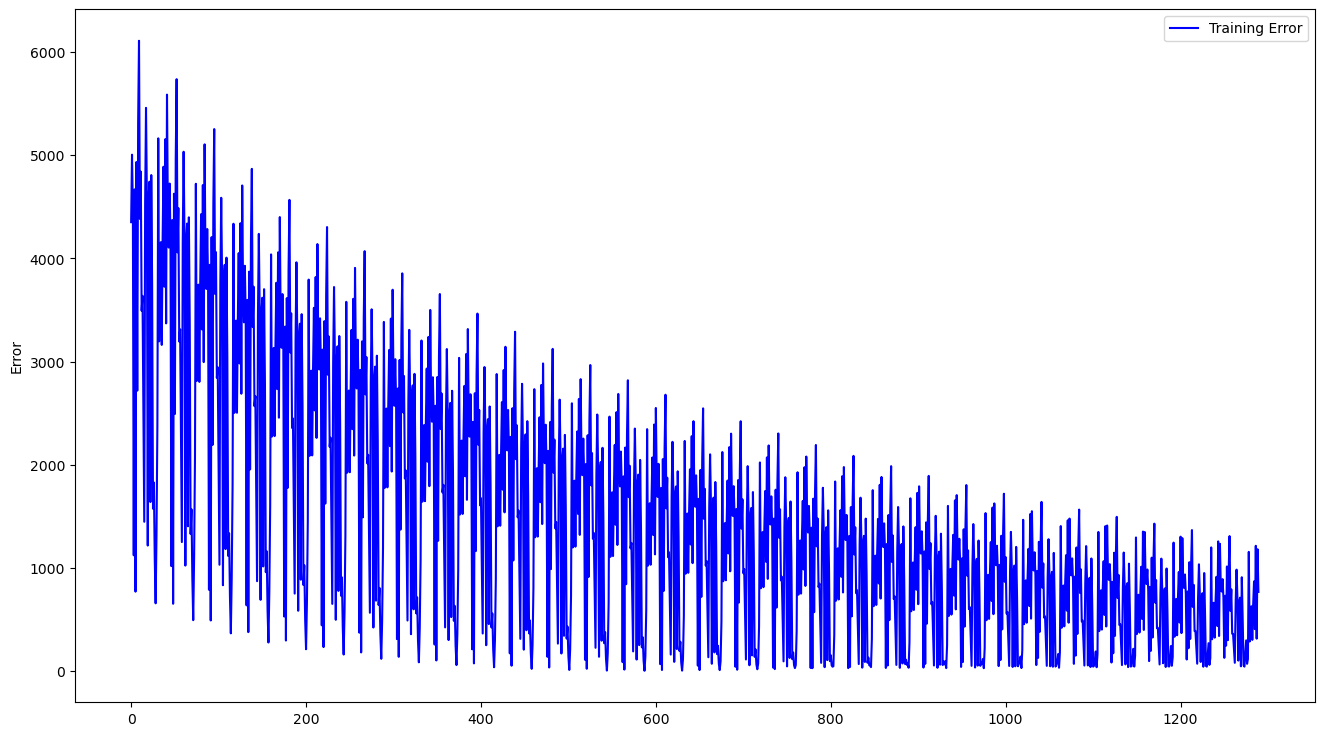

In [34]:
n_epochs = 30
seq_len = 100
number_of_features = len(df.columns) -2


#train model
train_losses = []

model_LSTM.train()
for epoch in range(n_epochs):
    for X, y in training_set:
        optimizer.zero_grad()
        out = model_LSTM.forward(X.view(-1, seq_len, number_of_features))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

Loss: 524.2222


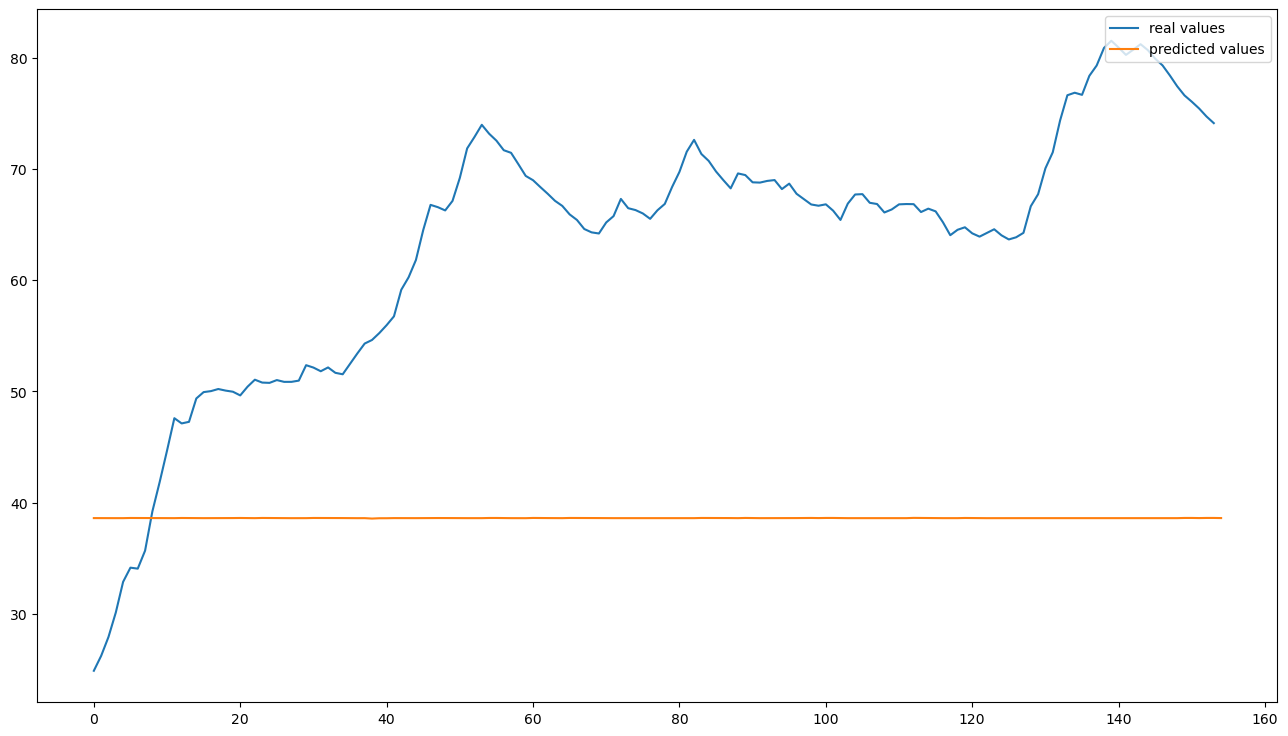

In [35]:
model_LSTM.eval()

#evaluation on session 80 and 81
session_80 = df[df["profile_id"] == 80]
session_80 = session_80.iloc[:15500]

y = session_80["pm"]
X = session_80.drop(["pm", "profile_id"], axis=1)

X_80 = torch.from_numpy(X.values[:22000, :]).float() 
y_80 = torch.from_numpy(y.values[:22000]).float()

out = model_LSTM.forward(X_80.view(-1, seq_len, 7))
loss = criterion(out, y_80.view(-1, seq_len, 1))
print("Loss: " + str(loss.detach().numpy()))

out = out[:, -1, :]
pred = out.detach().numpy().flatten()
real = y_80.numpy()[seq_len::seq_len]

plt.plot(real.flatten(), label="real values")
plt.plot(pred, label="predicted values")
plt.legend(loc='upper right')
plt.show()

**LSTM with scaled Features**

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
excluding_features = ['pm', 'profile_id']
df_excluding_features = df.drop(excluding_features, axis=1)
scaler.fit(df_excluding_features)

df_scaled = scaler.transform(df_excluding_features)

pm_column = df['pm'].values
profile_id_column = df['profile_id'].values
scaled_df = np.column_stack((df_scaled, pm_column, profile_id_column))

scaled_df = pd.DataFrame(scaled_df, columns=df.columns)




In [37]:
#trim sessions
training_set = preprocess(scaled_df, training_ids, seq_len)

#create an lstm instance
model_LSTM_scaled = NET(7, 20, 2, 1)
print(model_LSTM_scaled)

#define optimizer and loss function
optimizer = torch.optim.Adam(model_LSTM_scaled.parameters(), lr=0.01)
criterion = nn.MSELoss()

NET(
  (lstm): LSTM(7, 20, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


Epoch [1/30], Loss: 0.0403
Epoch [2/30], Loss: 0.0383
Epoch [3/30], Loss: 0.0412
Epoch [4/30], Loss: 0.0389
Epoch [5/30], Loss: 0.0432
Epoch [6/30], Loss: 0.0616
Epoch [7/30], Loss: 0.0435
Epoch [8/30], Loss: 0.0417
Epoch [9/30], Loss: 0.0362
Epoch [10/30], Loss: 0.0377
Epoch [11/30], Loss: 0.0370
Epoch [12/30], Loss: 0.0397
Epoch [13/30], Loss: 0.0384
Epoch [14/30], Loss: 0.0363
Epoch [15/30], Loss: 0.0377
Epoch [16/30], Loss: 0.0371
Epoch [17/30], Loss: 0.0378
Epoch [18/30], Loss: 0.0375
Epoch [19/30], Loss: 0.0371
Epoch [20/30], Loss: 0.0378
Epoch [21/30], Loss: 0.0379
Epoch [22/30], Loss: 0.0381
Epoch [23/30], Loss: 0.0369
Epoch [24/30], Loss: 0.0390
Epoch [25/30], Loss: 0.0386
Epoch [26/30], Loss: 0.0382
Epoch [27/30], Loss: 0.0364
Epoch [28/30], Loss: 0.0386
Epoch [29/30], Loss: 0.0396
Epoch [30/30], Loss: 0.0383


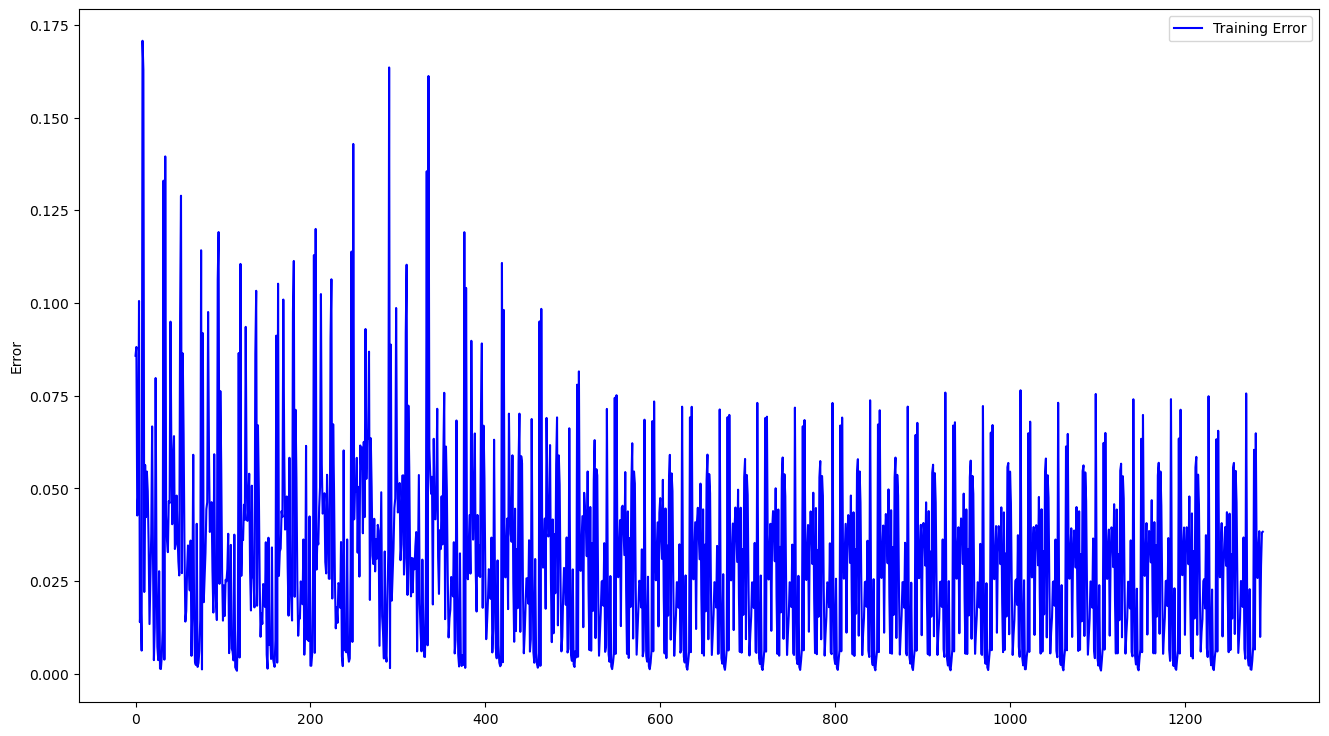

In [38]:
n_epochs = 30
seq_len = 100
number_of_features = len(df.columns) -2


#train model
train_losses = []

model_LSTM_scaled.train()
for epoch in range(n_epochs):
    for X, y in training_set:
        optimizer.zero_grad()
        out = model_LSTM_scaled.forward(X.view(-1, seq_len, number_of_features))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

Loss: 0.01973292


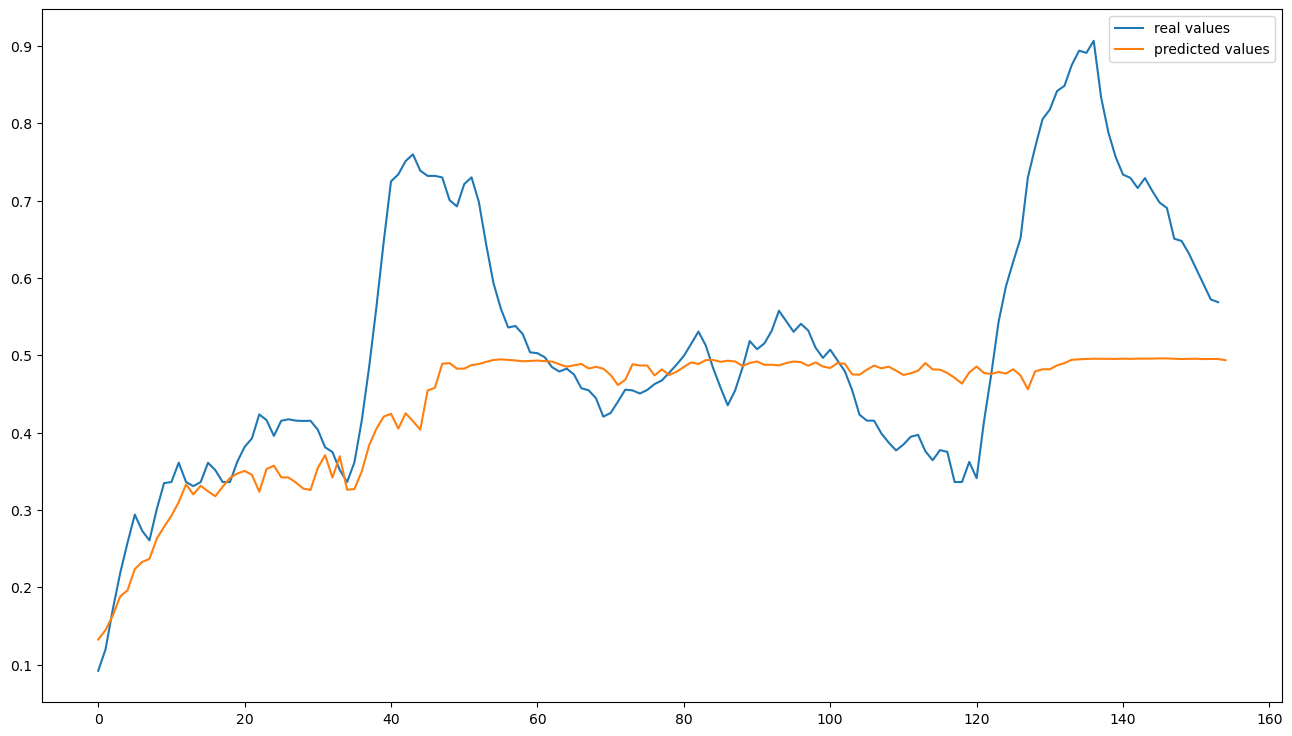

In [39]:
model_LSTM_scaled.eval()

#evaluation on session 80 and 81
session_80 = scaled_df[scaled_df["profile_id"] == 80]
session_80 = session_80.iloc[:15500]

y = session_80["pm"]
X = session_80.drop(["pm", "profile_id"], axis=1)

X_80 = torch.from_numpy(X.values[:22000, :]).float() 
y_80 = torch.from_numpy(y.values[:22000]).float()

out = model_LSTM_scaled.forward(X_80.view(-1, seq_len, 7))
loss = criterion(out, y_80.view(-1, seq_len, 1))
print("Loss: " + str(loss.detach().numpy()))

out = out[:, -1, :]
pred = out.detach().numpy().flatten()
real = y_80.numpy()[seq_len::seq_len]

plt.plot(real.flatten(), label="real values")
plt.plot(pred, label="predicted values")
plt.legend(loc='upper right')
plt.show()

**LSTM with scaled Features and Rolling Mean Window**

In [41]:
def preprocess_with_rolling_mean_std(df, sessions_id, seq_len, window_size, mean_std, target="pm"):
    sessions = []
    for id in sessions_id:
        s = df[df["profile_id"] == id]


        if mean_std == 1:
            # Apply rolling mean
            s_rolled = s.rolling(window=window_size, min_periods=1).mean()
        if mean_std ==2:
            s_rolled = s.rolling(window=window_size, min_periods=1).std().fillna(0)

        r = len(s_rolled) % seq_len
        l = len(s_rolled) - r

        session = s_rolled.iloc[:l]

        y = session[target]
        X = session.drop([target, "profile_id"], axis=1)

        X = torch.from_numpy(X.values).float()
        y = torch.from_numpy(y.values).float()

        sessions.append((X, y))

    return sessions


In [42]:
window_size = 40
sessions_mean = preprocess_with_rolling_mean_std(scaled_df, training_ids, seq_len, window_size, 1)


In [43]:
#create an lstm instance
model_LSTM_scaled_window = NET(7, 20, 2, 1)
print(model_LSTM_scaled_window)

#define optimizer and loss function
optimizer = torch.optim.Adam(model_LSTM_scaled_window.parameters(), lr=0.01)
criterion = nn.MSELoss()

NET(
  (lstm): LSTM(7, 20, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


Epoch [1/30], Loss: 0.0937
Epoch [2/30], Loss: 0.0757
Epoch [3/30], Loss: 0.0630
Epoch [4/30], Loss: 0.0660
Epoch [5/30], Loss: 0.0730
Epoch [6/30], Loss: 0.0645
Epoch [7/30], Loss: 0.0702
Epoch [8/30], Loss: 0.0672
Epoch [9/30], Loss: 0.0632
Epoch [10/30], Loss: 0.0799
Epoch [11/30], Loss: 0.0688
Epoch [12/30], Loss: 0.0722
Epoch [13/30], Loss: 0.0606
Epoch [14/30], Loss: 0.0661
Epoch [15/30], Loss: 0.0651
Epoch [16/30], Loss: 0.0656
Epoch [17/30], Loss: 0.0623
Epoch [18/30], Loss: 0.0689
Epoch [19/30], Loss: 0.0599
Epoch [20/30], Loss: 0.0610
Epoch [21/30], Loss: 0.0656
Epoch [22/30], Loss: 0.0580
Epoch [23/30], Loss: 0.0611
Epoch [24/30], Loss: 0.0647
Epoch [25/30], Loss: 0.0590
Epoch [26/30], Loss: 0.0618
Epoch [27/30], Loss: 0.0628
Epoch [28/30], Loss: 0.0611
Epoch [29/30], Loss: 0.0574
Epoch [30/30], Loss: 0.0586


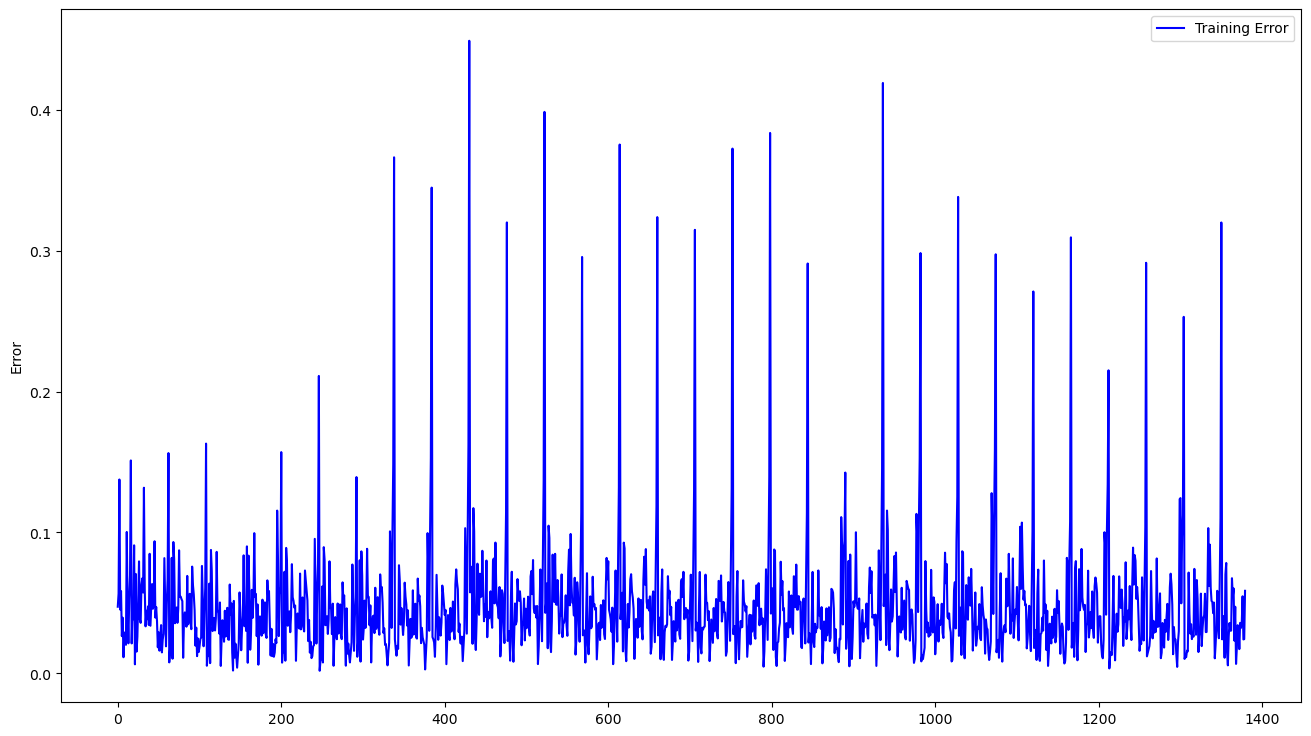

In [44]:
n_epochs = 30
seq_len = 100
number_of_features = len(df.columns) -2


#train model
train_losses = []

model_LSTM_scaled_window.train()
for epoch in range(n_epochs):
    for X, y in sessions_mean:
        optimizer.zero_grad()
        out = model_LSTM_scaled_window.forward(X.view(-1, seq_len, number_of_features))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

**LSTM with standardized features**

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
excluding_features = ['pm', 'profile_id']
df_excluding_features = df.drop(excluding_features, axis=1)

# Fit the scaler to the features excluding 'pm' and 'profile_id'
scaler.fit(df_excluding_features)

# Transform the features to a standardized scale
df_standardize = scaler.transform(df_excluding_features)

# Extract the 'pm' and 'profile_id' columns
pm_column = df['pm'].values
profile_id_column = df['profile_id'].values

# Combine the scaled features with the 'pm' and 'profile_id' columns
df_standardize = np.column_stack((df_standardize, pm_column, profile_id_column))

# Convert the array back to a pandas DataFrame and use the original column names
df_standardize = pd.DataFrame(df_standardize, columns=df.columns)


In [41]:
#trim sessions
training_set = preprocess(df_standardize, training_ids, seq_len)

#create an lstm instance
model_LSTM_standardize = NET(7, 20, 2, 1)
print(model_LSTM_scaled)

#define optimizer and loss function
optimizer = torch.optim.Adam(model_LSTM_standardize.parameters(), lr=0.01)
criterion = nn.MSELoss()

NET(
  (lstm): LSTM(7, 20, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


Epoch [1/30], Loss: 1.3020
Epoch [2/30], Loss: 0.9296
Epoch [3/30], Loss: 1.1701
Epoch [4/30], Loss: 1.8761
Epoch [5/30], Loss: 1.0616
Epoch [6/30], Loss: 0.7447
Epoch [7/30], Loss: 0.7955
Epoch [8/30], Loss: 0.7823
Epoch [9/30], Loss: 0.7251
Epoch [10/30], Loss: 0.5193
Epoch [11/30], Loss: 0.6518
Epoch [12/30], Loss: 0.7129
Epoch [13/30], Loss: 0.5652
Epoch [14/30], Loss: 0.5895
Epoch [15/30], Loss: 0.5963
Epoch [16/30], Loss: 0.5425
Epoch [17/30], Loss: 0.5220
Epoch [18/30], Loss: 0.5017
Epoch [19/30], Loss: 0.4899
Epoch [20/30], Loss: 0.4690
Epoch [21/30], Loss: 0.4569
Epoch [22/30], Loss: 0.4453
Epoch [23/30], Loss: 0.4331
Epoch [24/30], Loss: 0.4204
Epoch [25/30], Loss: 0.4138
Epoch [26/30], Loss: 0.4187
Epoch [27/30], Loss: 0.3880
Epoch [28/30], Loss: 0.3965
Epoch [29/30], Loss: 0.3713
Epoch [30/30], Loss: 0.3695


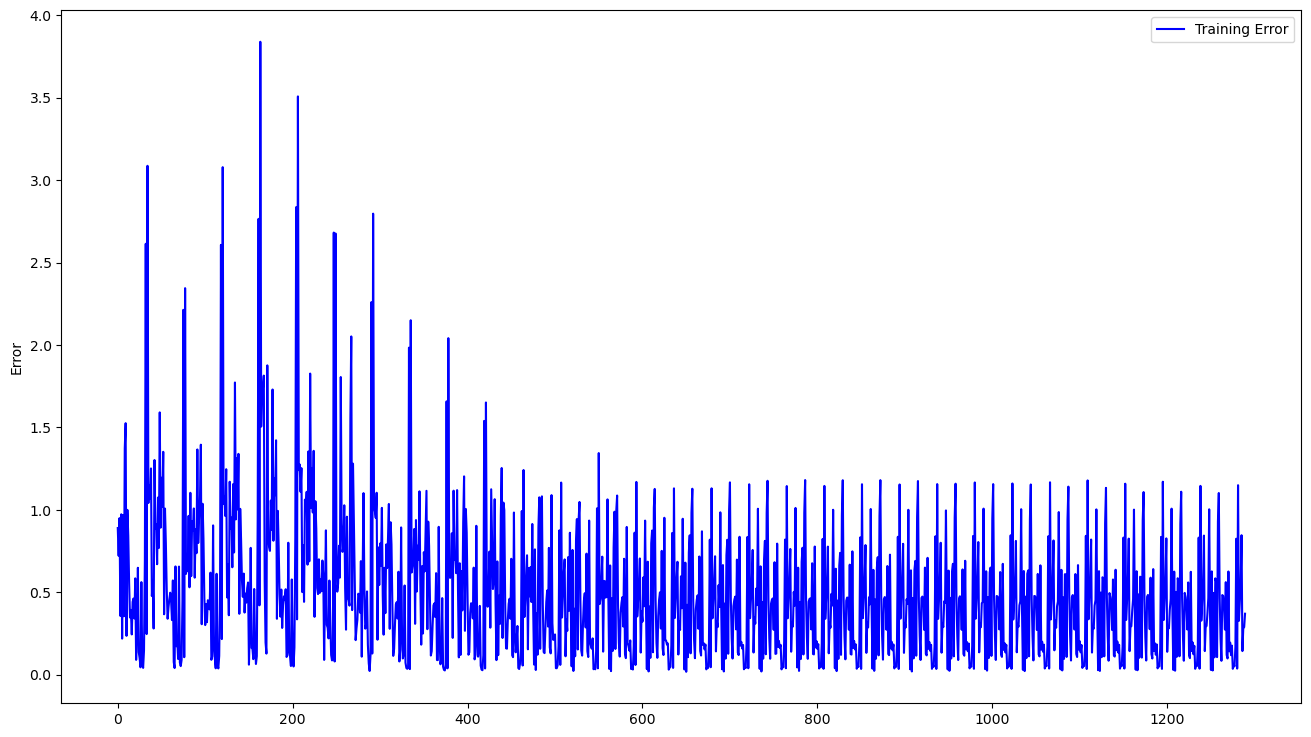

In [42]:
n_epochs = 30
seq_len = 100
number_of_features = len(df.columns) -2


#train model
train_losses = []

model_LSTM_standardize.train()
for epoch in range(n_epochs):
    for X, y in training_set:
        optimizer.zero_grad()
        out = model_LSTM_standardize.forward(X.view(-1, seq_len, number_of_features))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

Loss: 0.41316307


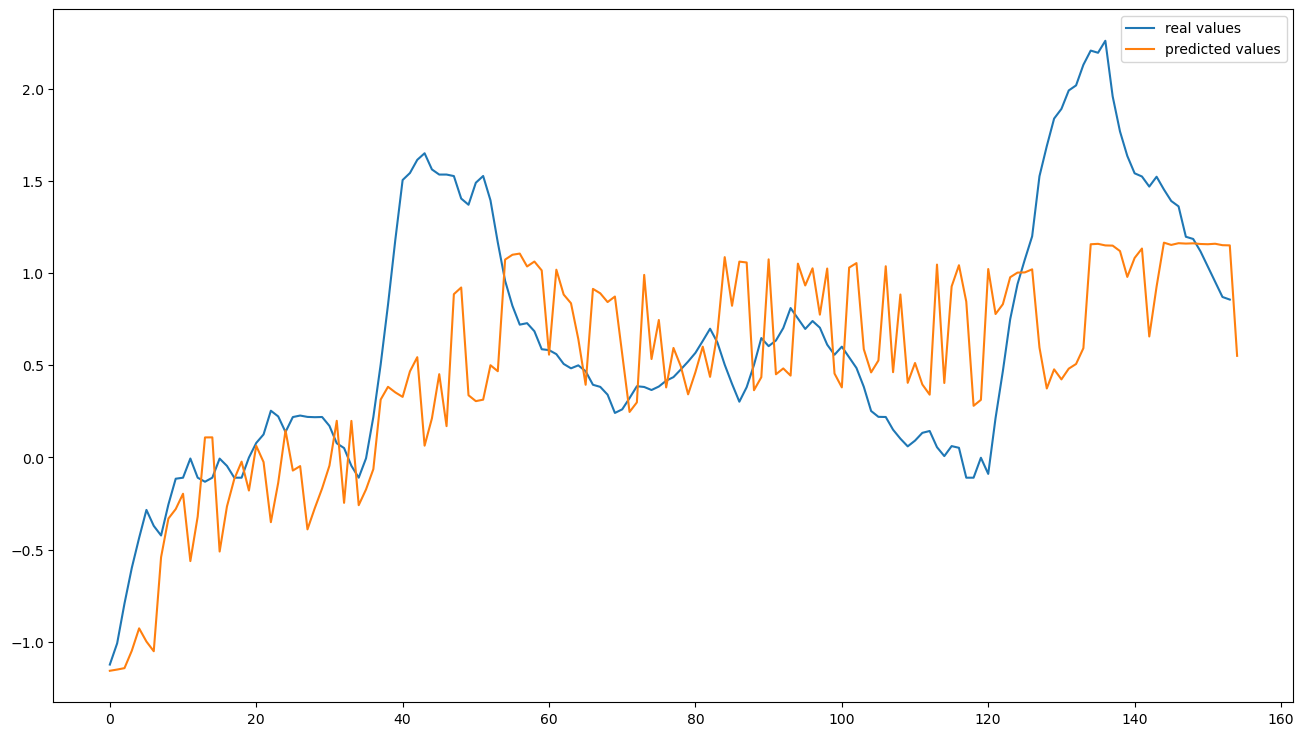

In [43]:
model_LSTM_standardize.eval()

#evaluation on session 80 and 81
session_80 = df_standardize[df_standardize["profile_id"] == 80]
session_80 = session_80.iloc[:15500]

y = session_80["pm"]
X = session_80.drop(["pm", "profile_id"], axis=1)

X_80 = torch.from_numpy(X.values[:22000, :]).float() 
y_80 = torch.from_numpy(y.values[:22000]).float()

out = model_LSTM_standardize.forward(X_80.view(-1, seq_len, 7))
loss = criterion(out, y_80.view(-1, seq_len, 1))
print("Loss: " + str(loss.detach().numpy()))

out = out[:, -1, :]
pred = out.detach().numpy().flatten()
real = y_80.numpy()[seq_len::seq_len]

plt.plot(real.flatten(), label="real values")
plt.plot(pred, label="predicted values")
plt.legend(loc='upper right')
plt.show()